In [4]:
# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming your dataset is loaded into `df` DataFrame and the target is 'JobSatisfaction'
# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print all rows of the DataFrame
print(df)
df.head()

        JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0        Very Satisfied                2                  7      30-39   
1        Very Satisfied                2                  7      30-39   
2        Very Satisfied                5                  6      20-29   
3        Very Satisfied                3                  7      20-29   
4        Very Satisfied                2                  4      20-29   
5        Very Satisfied                4                  6      30-39   
6        Very Satisfied                1                  5      20-29   
7        Very Satisfied                4                  5      20-29   
8        Very Satisfied                1                  8      20-29   
9        Very Satisfied                4                  8      20-29   
10       Very Satisfied                2                  6      40-49   
11       Very Satisfied                2                  6      30-39   
12       Very Satisfied               

,JobSatisfaction,Workload_Binned,SleepHours_Binned,Age_Binned,Stress_Binned,Experience_Binned,JobLevel,Gender,MaritalStatus,Dept,EmpType,haveOT_Binned
0,Very Satisfied,2,7,30-39,1,6-10,Mid,Male,Married,IT,Full-Time,Yes
1,Very Satisfied,2,7,30-39,2,11-15,Mid,Female,Married,Finance,Full-Time,No
2,Very Satisfied,5,6,20-29,4,1-5,Intern/Fresher,Female,Single,Marketing,Full-Time,Yes
3,Very Satisfied,3,7,20-29,1,6-10,Junior,Female,Married,IT,Contract,Yes
4,Very Satisfied,2,4,20-29,1,1-5,Junior,Other,Single,Sales,Part-Time,No


In [7]:
# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print the first few rows of the DataFrame
print(df.head())

# List of significant features
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction'])  # Ensure y is a 1D array

# Check unique classes in y
print("Unique classes in target variable:", np.unique(y))

# Prepare to save results to a text file
with open('naive_bayes_results.txt', 'w') as f:
    # Step 1: Set up Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)

        # AUC Calculation
        try:
            auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')
        except ValueError as e:
            print(f"Error calculating AUC: {e}")
            auc_nb = None  # Handle the case where AUC cannot be computed

        acc_nb = accuracy_score(y_val, y_pred_nb)

        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}\n" if auc_nb is not None else "AUC: N/A, Accuracy: {acc_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate Naive Bayes on the test set
    nb_model.fit(X_train, y_train)
    y_test_pred_nb = nb_model.predict(X_test)
    y_test_prob_nb = nb_model.predict_proba(X_test)

    # AUC Calculation for the test set
    try:
        final_auc_nb = roc_auc_score(y_test, y_test_prob_nb, multi_class='ovr')
    except ValueError as e:
        print(f"Error calculating final AUC: {e}")
        final_auc_nb = None

    final_acc_nb = accuracy_score(y_test, y_test_pred_nb)

    final_result_str_nb = f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: {final_auc_nb:.4f}, Accuracy: {final_acc_nb:.4f}\n" if final_auc_nb is not None else f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: N/A, Accuracy: {final_acc_nb:.4f}\n"
    print(final_result_str_nb.strip())
    f.write(final_result_str_nb)

# Step 7: Plotting ROC Curve for Naive Bayes
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)

    # Plot ROC curves for each class
    for i in range(y_prob.shape[1]):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC for Naive Bayes if AUC was calculated successfully
if final_auc_nb is not None:
    plot_best_roc(nb_model, X_test, y_test)

  JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0  Very Satisfied                2                  7      30-39   
1  Very Satisfied                2                  7      30-39   
2  Very Satisfied                5                  6      20-29   
3  Very Satisfied                3                  7      20-29   
4  Very Satisfied                2                  4      20-29   

   Stress_Binned Experience_Binned        JobLevel  Gender MaritalStatus  \
0              1              6-10             Mid    Male       Married   
1              2             11-15             Mid  Female       Married   
2              4               1-5  Intern/Fresher  Female        Single   
3              1              6-10          Junior  Female       Married   
4              1               1-5          Junior   Other        Single   

        Dept    EmpType haveOT_Binned  
0         IT  Full-Time           Yes  
1    Finance  Full-Time            No  
2  Marketing  

ValueError: multi_class must be in ('ovo', 'ovr')

  JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0  Very Satisfied                2                  7      30-39   
1  Very Satisfied                2                  7      30-39   
2  Very Satisfied                5                  6      20-29   
3  Very Satisfied                3                  7      20-29   
4  Very Satisfied                2                  4      20-29   

   Stress_Binned Experience_Binned        JobLevel  Gender MaritalStatus  \
0              1              6-10             Mid    Male       Married   
1              2             11-15             Mid  Female       Married   
2              4               1-5  Intern/Fresher  Female        Single   
3              1              6-10          Junior  Female       Married   
4              1               1-5          Junior   Other        Single   

        Dept    EmpType haveOT_Binned  
0         IT  Full-Time           Yes  
1    Finance  Full-Time            No  
2  Marketing  

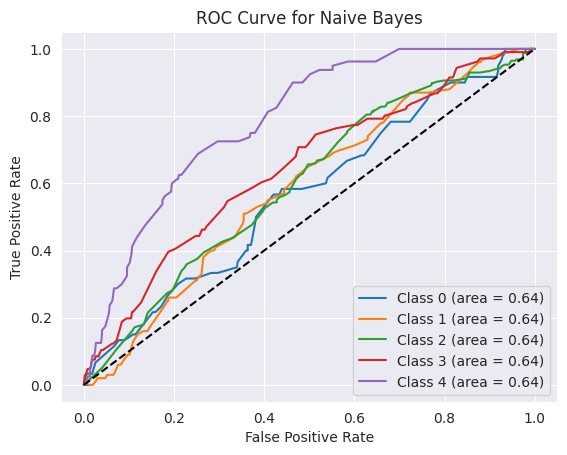

In [11]:
# Import libraries
import pandas as pd
import os
from skopt import BayesSearchCV
from skopt.space im# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print the first few rows of the DataFrame
print(df.head())

# List of significant features
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction'])  # Ensure y is a 1D array

# Check unique classes in y
print("Unique classes in target variable:", np.unique(y))

# Prepare to save results to a text file
with open('naive_bayes_results.txt', 'w') as f:
    # Step 1: Set up Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)

        # AUC Calculation
        try:
            auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')
        except ValueError as e:
            print(f"Error calculating AUC: {e}")
            auc_nb = None  # Handle the case where AUC cannot be computed

        acc_nb = accuracy_score(y_val, y_pred_nb)
        f1_nb = f1_score(y_val, y_pred_nb, average='weighted')

        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}, F1 Score: {f1_nb:.4f}\n" if auc_nb is not None else "AUC: N/A, Accuracy: {acc_nb:.4f}, F1 Score: {f1_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate Naive Bayes on the test set
    nb_model.fit(X_train, y_train)
    y_test_pred_nb = nb_model.predict(X_test)
    y_test_prob_nb = nb_model.predict_proba(X_test)

    # AUC Calculation for the test set
    try:
        final_auc_nb = roc_auc_score(y_test, y_test_prob_nb, multi_class='ovr')
    except ValueError as e:
        print(f"Error calculating final AUC: {e}")
        final_auc_nb = None

    final_acc_nb = accuracy_score(y_test, y_test_pred_nb)
    final_f1_nb = f1_score(y_test, y_test_pred_nb, average='weighted')

    final_result_str_nb = f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: {final_auc_nb:.4f}, Accuracy: {final_acc_nb:.4f}, F1 Score: {final_f1_nb:.4f}\n" if final_auc_nb is not None else f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: N/A, Accuracy: {final_acc_nb:.4f}, F1 Score: {final_f1_nb:.4f}\n"
    print(final_result_str_nb.strip())
    f.write(final_result_str_nb)

# Step 7: Plotting ROC Curve for Naive Bayes
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)
    
    # Calculate and plot ROC curves for each class
    for i in range(y_prob.shape[1]):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob, multi_class="ovr"):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC for Naive Bayes if AUC was calculated successfully
if final_auc_nb is not None:
    plot_best_roc(nb_model, X_test, y_test)port Categorical, Integer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print the first few rows of the DataFrame
print(df.head())

# List of significant features
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction'])  # Ensure y is a 1D array

# Check unique classes in y
print("Unique classes in target variable:", np.unique(y))

# Prepare to save results to a text file
with open('naive_bayes_results.txt', 'w') as f:
    # Step 1: Set up Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)

        # AUC Calculation
        try:
            auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')
        except ValueError as e:
            print(f"Error calculating AUC: {e}")
            auc_nb = None  # Handle the case where AUC cannot be computed

        acc_nb = accuracy_score(y_val, y_pred_nb)
        f1_nb = f1_score(y_val, y_pred_nb, average='weighted')

        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}, F1 Score: {f1_nb:.4f}\n" if auc_nb is not None else "AUC: N/A, Accuracy: {acc_nb:.4f}, F1 Score: {f1_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate Naive Bayes on the test set
    nb_model.fit(X_train, y_train)
    y_test_pred_nb = nb_model.predict(X_test)
    y_test_prob_nb = nb_model.predict_proba(X_test)

    # AUC Calculation for the test set
    try:
        final_auc_nb = roc_auc_score(y_test, y_test_prob_nb, multi_class='ovr')
    except ValueError as e:
        print(f"Error calculating final AUC: {e}")
        final_auc_nb = None

    final_acc_nb = accuracy_score(y_test, y_test_pred_nb)
    final_f1_nb = f1_score(y_test, y_test_pred_nb, average='weighted')

    final_result_str_nb = f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: {final_auc_nb:.4f}, Accuracy: {final_acc_nb:.4f}, F1 Score: {final_f1_nb:.4f}\n" if final_auc_nb is not None else f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: N/A, Accuracy: {final_acc_nb:.4f}, F1 Score: {final_f1_nb:.4f}\n"
    print(final_result_str_nb.strip())
    f.write(final_result_str_nb)

# Step 7: Plotting ROC Curve for Naive Bayes
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)
    
    # Calculate and plot ROC curves for each class
    for i in range(y_prob.shape[1]):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob, multi_class="ovr"):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC for Naive Bayes if AUC was calculated successfully
if final_auc_nb is not None:
    plot_best_roc(nb_model, X_test, y_test)

Certainly! Let's break down the output you're seeing and explain what's happening in the script:

1. Bayesian Optimization Warnings:
   The warnings you're seeing (e.g., "The objective has been evaluated at point [np.int64(2), np.False_] before, using random point [np.int64(3), False]") are coming from the Bayesian optimization process. These warnings indicate that the optimizer is encountering duplicate points or very similar points in the parameter space. This is not necessarily a problem, but it suggests that the parameter space might be relatively small or that the objective function doesn't vary much across different parameter values.

2. Best Hyperparameters:
   ```
   Best hyperparameters: OrderedDict({'poly__degree': 1, 'poly__include_bias': False})
   ```
   This shows the best combination of hyperparameters found by the Bayesian optimization process. In this case, it suggests that a polynomial degree of 1 (which is equivalent to no polynomial features) and not including a bias term gave the best results.

3. Final Evaluation Metrics:
   ```
   Final Evaluation on Test Set:
   AUC: 0.6267, Accuracy: 0.4252, F1 Score: 0.3108
   ```
   These are the performance metrics of your model on the test set:
   - AUC (Area Under the ROC Curve): 0.6267 - This suggests that the model has some discriminative power, but it's not very strong. A perfect classifier would have an AUC of 1.0, while a random classifier would have an AUC of 0.5.
   - Accuracy: 0.4252 - This means the model correctly classifies about 42.52% of the samples. For a multiclass problem, this might not be too bad, depending on the number of classes and the difficulty of the problem.
   - F1 Score: 0.3108 - This is the harmonic mean of precision and recall. The relatively low F1 score suggests that the model struggles with balancing precision and recall across the classes.

4. Figure Output:
   ```
   <Figure size 640x480 with 1 Axes>
   ```
   This indicates that a matplotlib figure was created, which should be the ROC curve plot. However, it seems that the plot wasn't displayed or saved properly. This could be due to the environment you're running the script in (e.g., if it's a non-interactive environment).

Overall, what's happening is:
1. The script is performing Bayesian optimization to find the best hyperparameters for your Naive Bayes model with polynomial features.
2. It's finding that simple linear features (polynomial degree 1) without bias perform best.
3. The model's performance is moderate - it's better than random guessing, but there's still room for improvement.
4. The ROC curve is being generated but may not be displaying properly in your environment.

To improve this:
1. You might want to expand your hyperparameter search space to include more options.
2. Consider trying other preprocessing steps or feature engineering techniques.
3. You may need to add `plt.savefig('roc_curve.png')` before `plt.show()` in the `plot_multiclass_roc` function to save the ROC curve plot as an image file.
4. If the model's performance is still not satisfactory, you might want to consider trying other classification algorithms that might be more suitable for your specific problem.

Let me know if you want to make any specific improvements or if you have any questions about these results!

In [12]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# List of significant features
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction'])

# Create a pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('nb', GaussianNB())
])

# Define the hyperparameters space
hyperparameters = {
    'poly__degree': Integer(1, 3),
    'poly__include_bias': Categorical([True, False])
}

# Set up Bayesian search for hyperparameter optimization
bayessearch = BayesSearchCV(
    pipeline,
    hyperparameters,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc_ovr',
    n_jobs=-1,
    random_state=42
)

# Prepare to save results to a text file
with open('naive_bayes_results.txt', 'w') as f:
    # Perform Bayesian optimization
    print("Performing Bayesian optimization for hyperparameter tuning...")
    f.write("Performing Bayesian optimization for hyperparameter tuning...\n")
    bayessearch.fit(X, y)
    
    print(f"Best hyperparameters: {bayessearch.best_params_}")
    f.write(f"Best hyperparameters: {bayessearch.best_params_}\n")

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use the best estimator for final evaluation
    best_model = bayessearch.best_estimator_
    best_model.fit(X_train, y_train)
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)

    # Calculate metrics
    final_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
    final_acc = accuracy_score(y_test, y_test_pred)
    final_f1 = f1_score(y_test, y_test_pred, average='weighted')

    final_result_str = f"\nFinal Evaluation on Test Set:\nAUC: {final_auc:.4f}, Accuracy: {final_acc:.4f}, F1 Score: {final_f1:.4f}\n"
    print(final_result_str.strip())
    f.write(final_result_str)

# Plotting ROC Curve
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)
    
    # Calculate and plot ROC curves for each class
    for i in range(y_prob.shape[1]):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob[:, i], average="weighted"):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Optimized Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve
plot_best_roc(best_model, X_test, y_test)

Performing Bayesian optimization for hyperparameter tuning...


/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.False_] before, using random point [np.int64(3), False]
  warnings.warn(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.False_] before, using random point [np.int64(2), True]
  warnings.warn(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.True_] before, using random point [np.int64(3), False]
  warnings.warn(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.True_] before, using random point [np.int64(2), True]
 

Best hyperparameters: OrderedDict({'poly__degree': 1, 'poly__include_bias': False})
Final Evaluation on Test Set:
AUC: 0.6367, Accuracy: 0.4252, F1 Score: 0.3108


ValueError: multi_class must be in ('ovo', 'ovr')

Performing Bayesian optimization for hyperparameter tuning...


/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.False_] before, using random point [np.int64(3), False]
  warnings.warn(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.False_] before, using random point [np.int64(2), True]
  warnings.warn(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(2), np.True_] before, using random point [np.int64(3), False]
  warnings.warn(
/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(3), np.True_] before, using random point [np.int64(2), True]
 

Best hyperparameters: OrderedDict({'poly__degree': 1, 'poly__include_bias': False})
Final Evaluation on Test Set:
AUC: 0.6267, Accuracy: 0.4252, F1 Score: 0.3108


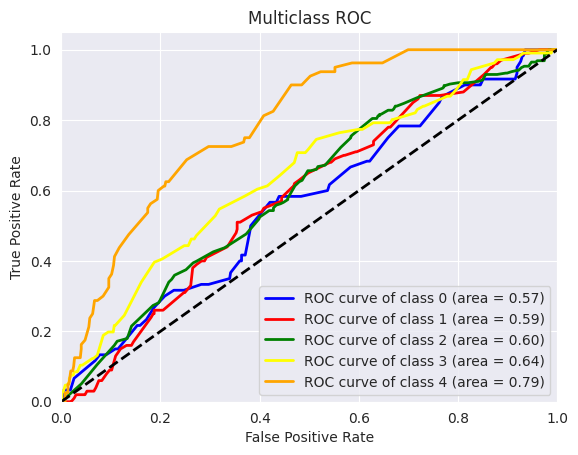

In [13]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# List of significant features
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction'])

# Create a pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('nb', GaussianNB())
])

# Define the hyperparameters space
hyperparameters = {
    'poly__degree': Integer(1, 3),
    'poly__include_bias': Categorical([True, False])
}

# Set up Bayesian search for hyperparameter optimization
bayessearch = BayesSearchCV(
    pipeline,
    hyperparameters,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc_ovr',
    n_jobs=-1,
    random_state=42
)

# Prepare to save results to a text file
with open('naive_bayes_results.txt', 'w') as f:
    # Perform Bayesian optimization
    print("Performing Bayesian optimization for hyperparameter tuning...")
    f.write("Performing Bayesian optimization for hyperparameter tuning...\n")
    bayessearch.fit(X, y)
    
    print(f"Best hyperparameters: {bayessearch.best_params_}")
    f.write(f"Best hyperparameters: {bayessearch.best_params_}\n")

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use the best estimator for final evaluation
    best_model = bayessearch.best_estimator_
    best_model.fit(X_train, y_train)
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)

    # Calculate metrics
    final_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr', average='weighted')
    final_acc = accuracy_score(y_test, y_test_pred)
    final_f1 = f1_score(y_test, y_test_pred, average='weighted')

    final_result_str = f"\nFinal Evaluation on Test Set:\nAUC: {final_auc:.4f}, Accuracy: {final_acc:.4f}, F1 Score: {final_f1:.4f}\n"
    print(final_result_str.strip())
    f.write(final_result_str)

# Plotting ROC Curve for multiclass
def plot_multiclass_roc(model, X, y):
    n_classes = len(np.unique(y))
    y_score = model.predict_proba(X)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y == i, y_score[:, i])
        roc_auc[i] = roc_auc_score(y == i, y_score[:, i])

    # Plot all ROC curves
    plt.figure()
    colors = ['blue', 'red', 'green', 'yellow', 'orange']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve
plot_multiclass_roc(best_model, X_test, y_test)

In [10]:
# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
missing_values = ['n/a', 'na', 'nan', 'N/A', 'NA', 'NaN', 'NAN', '--', 'Missing']
df = pd.read_csv('processed_features_job_satisfaction.csv', na_values=missing_values, sep=';', decimal='.')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print all rows of the DataFrame
print(df.head())

# List of significant features identified from chi-squared test
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']  # Replace with actual features

# Separate selected features and target variable
X = df[significant_features]  # Use only significant features
y = df['JobSatisfaction']      # Target

# Prepare to save results to a text file
with open('cross_validation_results.txt', 'w') as f:
    # Step 1: Set up K-Fold Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in kf.split(X, y):
        # Use iloc for indexing
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)
        auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')  # Use 'ovr' for multi-class
        acc_nb = accuracy_score(y_val, y_pred_nb)
        
        # Print and save the results directly
        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Step 3: Run K-Fold Cross-Validation for SVC with GridSearch
    f.write("\nCross-Validation Results for SVC:\n")
    print("\nCross-Validation Results for SVC:")
    
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }

    svc_model = SVC(probability=True)
    grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)

    # Fit the GridSearch model on the entire dataset
    grid_search.fit(X, y)
    best_svc_model = grid_search.best_estimator_

    for train_index, val_index in kf.split(X, y):
        # Use iloc for indexing
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        best_svc_model.fit(X_train, y_train)
        y_pred_svc = best_svc_model.predict(y_val)
        y_prob_svc = best_svc_model.predict_proba(X_val)
        auc_svc = roc_auc_score(y_val, y_prob_svc, multi_class='ovr')  # Use 'ovr' for multi-class
        acc_svc = accuracy_score(y_val, y_pred_svc)
        
        # Print and save the results directly
        result_str = f"AUC: {auc_svc:.4f}, Accuracy: {acc_svc:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Step 4: Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_svc_model.fit(X_train, y_train)
    y_test_pred = best_svc_model.predict(X_test)
    y_test_prob = best_svc_model.predict_proba(X_test)
    final_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')  # Use 'ovr' for multi-class
    final_acc = accuracy_score(y_test, y_test_pred)

    # Print and save the final evaluation results
    final_result_str = f"\nFinal Evaluation on Test Set for Best SVC Model:\nAUC: {final_auc:.4f}, Accuracy: {final_acc:.4f}\n"
    print(final_result_str.strip())
    f.write(final_result_str)

# Step 7: Plotting ROC Curve for Best Model
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)

    # Plot ROC curves for each class
    for i in range(len(model.classes_)):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)  # For multiclass
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Step 8: Plot ROC for Best Model
plot_best_roc(best_svc_model, X_test, y_test)


  JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0  Very Satisfied                2                  7      30-39   
1  Very Satisfied                2                  7      30-39   
2  Very Satisfied                5                  6      20-29   
3  Very Satisfied                3                  7      20-29   
4  Very Satisfied                2                  4      20-29   

   Stress_Binned Experience_Binned        JobLevel  Gender MaritalStatus  \
0              1              6-10             Mid    Male       Married   
1              2             11-15             Mid  Female       Married   
2              4               1-5  Intern/Fresher  Female        Single   
3              1              6-10          Junior  Female       Married   
4              1               1-5          Junior   Other        Single   

        Dept    EmpType haveOT_Binned  
0         IT  Full-Time           Yes  
1    Finance  Full-Time            No  
2  Marketing  

/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._

ValueError: could not convert string to float: 'Very Satisfied'

In [ ]:
#Kfold validation version

In [11]:
# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print all rows of the DataFrame
print(df.head())

# List of significant features identified from chi-squared test
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']  # Replace with actual features

# Separate selected features and target variable
X = df[significant_features]  # Use only significant features

# Encode the target variable to numeric labels
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction'])  # Transform string labels to integers

# Prepare to save results to a text file
with open('cross_validation_results.txt', 'w') as f:
    # Step 1: Set up K-Fold Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in kf.split(X, y):
        # Use iloc for indexing
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]  # Change to y indexing

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)
        auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')  # Use 'ovr' for multi-class
        acc_nb = accuracy_score(y_val, y_pred_nb)
        
        # Print and save the results directly
        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Step 3: Run K-Fold Cross-Validation for SVC with GridSearch
    f.write("\nCross-Validation Results for SVC:\n")
    print("\nCross-Validation Results for SVC:")
    
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }

    svc_model = SVC(probability=True)
    grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)

    # Fit the GridSearch model on the entire dataset
    grid_search.fit(X, y)
    best_svc_model = grid_search.best_estimator_

    for train_index, val_index in kf.split(X, y):
        # Use iloc for indexing
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]  # Change to y indexing

        best_svc_model.fit(X_train, y_train)
        y_pred_svc = best_svc_model.predict(y_val)
        y_prob_svc = best_svc_model.predict_proba(X_val)
        auc_svc = roc_auc_score(y_val, y_prob_svc, multi_class='ovr')  # Use 'ovr' for multi-class
        acc_svc = accuracy_score(y_val, y_pred_svc)
        
        # Print and save the results directly
        result_str = f"AUC: {auc_svc:.4f}, Accuracy: {acc_svc:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Step 4: Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_svc_model.fit(X_train, y_train)
    y_test_pred = best_svc_model.predict(X_test)
    y_test_prob = best_svc_model.predict_proba(X_test)
    final_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')  # Use 'ovr' for multi-class
    final_acc = accuracy_score(y_test, y_test_pred)

    # Print and save the final evaluation results
    final_result_str = f"\nFinal Evaluation on Test Set for Best SVC Model:\nAUC: {final_auc:.4f}, Accuracy: {final_acc:.4f}\n"
    print(final_result_str.strip())
    f.write(final_result_str)

# Step 7: Plotting ROC Curve for Best Model
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)

    # Plot ROC curves for each class
    for i in range(len(model.classes_)):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)  # For multiclass
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Step 8: Plot ROC for Best Model
plot_best_roc(best_svc_model, X_test, y_test)


  JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0  Very Satisfied                2                  7      30-39   
1  Very Satisfied                2                  7      30-39   
2  Very Satisfied                5                  6      20-29   
3  Very Satisfied                3                  7      20-29   
4  Very Satisfied                2                  4      20-29   

   Stress_Binned Experience_Binned        JobLevel  Gender MaritalStatus  \
0              1              6-10             Mid    Male       Married   
1              2             11-15             Mid  Female       Married   
2              4               1-5  Intern/Fresher  Female        Single   
3              1              6-10          Junior  Female       Married   
4              1               1-5          Junior   Other        Single   

        Dept    EmpType haveOT_Binned  
0         IT  Full-Time           Yes  
1    Finance  Full-Time            No  
2  Marketing  

/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._

ValueError: Expected 2D array, got 1D array instead:
array=[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 2. 2. 2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 3. 3. 3.
 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4.
 4. 4.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [13]:
# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print all rows of the DataFrame
print(df.head())

# List of significant features identified from chi-squared test
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate selected features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction']).reshape(-1, 1)  # Ensure y is treated as a 2D array if needed

# Prepare to save results to a text file
with open('cross_validation_results.txt', 'w') as f:
    # Step 1: Set up K-Fold Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in kf.split(X, y):
        # Use iloc for indexing
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index].ravel(), y[val_index].ravel()  # Flatten y for fitting

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)
        auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')
        acc_nb = accuracy_score(y_val, y_pred_nb)
        
        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Step 3: Run K-Fold Cross-Validation for SVC with GridSearch
    f.write("\nCross-Validation Results for SVC:\n")
    print("\nCross-Validation Results for SVC:")
    
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']  # Added more kernel types
    }

    svc_model = SVC(probability=True)
    grid_search = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X, y.ravel())  # Flatten y for fitting
    best_svc_model = grid_search.best_estimator_

    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index].ravel(), y[val_index].ravel()

        best_svc_model.fit(X_train, y_train)
        y_pred_svc = best_svc_model.predict(X_val)
        y_prob_svc = best_svc_model.predict_proba(X_val)
        auc_svc = roc_auc_score(y_val, y_prob_svc, multi_class='ovr')
        acc_svc = accuracy_score(y_val, y_pred_svc)
        
        result_str = f"AUC: {auc_svc:.4f}, Accuracy: {acc_svc:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Step 4: Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)
    best_svc_model.fit(X_train, y_train)
    y_test_pred = best_svc_model.predict(X_test)
    y_test_prob = best_svc_model.predict_proba(X_test)
    final_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
    final_acc = accuracy_score(y_test, y_test_pred)

    final_result_str = f"\nFinal Evaluation on Test Set for Best SVC Model:\nAUC: {final_auc:.4f}, Accuracy: {final_acc:.4f}\n"
    print(final_result_str.strip())
    f.write(final_result_str)

# Step 7: Plotting ROC Curve for Best Model
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)

    # Plot ROC curves for each class
    for i in range(len(model.classes_)):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Step 8: Plot ROC for Best Model
plot_best_roc(best_svc_model, X_test, y_test)

  JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0  Very Satisfied                2                  7      30-39   
1  Very Satisfied                2                  7      30-39   
2  Very Satisfied                5                  6      20-29   
3  Very Satisfied                3                  7      20-29   
4  Very Satisfied                2                  4      20-29   

   Stress_Binned Experience_Binned        JobLevel  Gender MaritalStatus  \
0              1              6-10             Mid    Male       Married   
1              2             11-15             Mid  Female       Married   
2              4               1-5  Intern/Fresher  Female        Single   
3              1              6-10          Junior  Female       Married   
4              1               1-5          Junior   Other        Single   

        Dept    EmpType haveOT_Binned  
0         IT  Full-Time           Yes  
1    Finance  Full-Time            No  
2  Marketing  

/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._

KeyboardInterrupt: 

In [15]:
# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print all rows of the DataFrame
print(df.head())

# List of significant features identified from chi-squared test
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate selected features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction']).ravel()  # Ensure y is a 1D array

# Prepare to save results to a text file
with open('cross_validation_results.txt', 'w') as f:
    # Step 1: Set up Repeated Stratified K-Fold Cross-Validation
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    # Define models to evaluate
    models = {
        'Naive Bayes': GaussianNB(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'SVC': SVC(probability=True)
    }

    # Hyperparameter grids
    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'subsample': [0.8, 0.9, 1.0]
        },
        'SVC': {
            'C': [0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'kernel': ['linear', 'rbf', 'poly']
        }
    }

    for name, model in models.items():
        f.write(f"\nCross-Validation Results for {name}:\n")
        print(f"\nCross-Validation Results for {name}:")

        # Check if the model has hyperparameters to tune
        if name in param_grids:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=rskf, scoring='roc_auc', n_jobs=-1)
            grid_search.fit(X, y)
            best_model = grid_search.best_estimator_
            f.write(f"Best Parameters: {grid_search.best_params_}\n")
            print(f"Best Parameters: {grid_search.best_params_}")

        else:
            best_model = model

        # K-Fold Cross-Validation
        for train_index, val_index in rskf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y[train_index], y[val_index]

            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_val)
            y_prob = best_model.predict_proba(X_val)
            auc = roc_auc_score(y_val, y_prob, multi_class='ovr')
            acc = accuracy_score(y_val, y_pred)

            result_str = f"AUC: {auc:.4f}, Accuracy: {acc:.4f}\n"
            print(result_str.strip())
            f.write(result_str)

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    best_model.fit(X_train, y_train)
    y_test_pred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)
    final_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
    final_acc = accuracy_score(y_test, y_test_pred)

    final_result_str = f"\nFinal Evaluation on Test Set for Best Model:\nAUC: {final_auc:.4f}, Accuracy: {final_acc:.4f}\n"
    print(final_result_str.strip())
    f.write(final_result_str)

# Step 7: Plotting ROC Curve for Best Model
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)

    # Plot ROC curves for each class
    for i in range(len(model.classes_)):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Step 8: Plot ROC for Best Model
plot_best_roc(best_model, X_test, y_test)

  JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0  Very Satisfied                2                  7      30-39   
1  Very Satisfied                2                  7      30-39   
2  Very Satisfied                5                  6      20-29   
3  Very Satisfied                3                  7      20-29   
4  Very Satisfied                2                  4      20-29   

   Stress_Binned Experience_Binned        JobLevel  Gender MaritalStatus  \
0              1              6-10             Mid    Male       Married   
1              2             11-15             Mid  Female       Married   
2              4               1-5  Intern/Fresher  Female        Single   
3              1              6-10          Junior  Female       Married   
4              1               1-5          Junior   Other        Single   

        Dept    EmpType haveOT_Binned  
0         IT  Full-Time           Yes  
1    Finance  Full-Time            No  
2  Marketing  

/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zamlamb/KdG/Data n AI 5/Team-Stress/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._

In [1]:
# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print all rows of the DataFrame
print(df.head())

# List of significant features identified from chi-squared test
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate selected features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction']).ravel()  # Ensure y is a 1D array

# Prepare to save results to a text file
with open('cross_validation_results.txt', 'w') as f:
    # Step 1: Set up Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)
        auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')
        acc_nb = accuracy_score(y_val, y_pred_nb)

        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Step 3: Simplified SVC Model
    svc_model = SVC(probability=True, C=1.0, kernel='rbf', gamma='scale')  # Simple SVC settings
    f.write("\nCross-Validation Results for SVC:\n")
    print("\nCross-Validation Results for SVC:")
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        svc_model.fit(X_train, y_train)
        y_pred_svc = svc_model.predict(X_val)
        y_prob_svc = svc_model.predict_proba(X_val)
        auc_svc = roc_auc_score(y_val, y_prob_svc, multi_class='ovr')
        acc_svc = accuracy_score(y_val, y_pred_svc)

        result_str = f"AUC: {auc_svc:.4f}, Accuracy: {acc_svc:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate Naive Bayes
    nb_model.fit(X_train, y_train)
    y_test_pred_nb = nb_model.predict(X_test)
    y_test_prob_nb = nb_model.predict_proba(X_test)
    final_auc_nb = roc_auc_score(y_test, y_test_prob_nb, multi_class='ovr')
    final_acc_nb = accuracy_score(y_test, y_test_pred_nb)

    final_result_str_nb = f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: {final_auc_nb:.4f}, Accuracy: {final_acc_nb:.4f}\n"
    print(final_result_str_nb.strip())
    f.write(final_result_str_nb)

    # Evaluate SVC
    svc_model.fit(X_train, y_train)
    y_test_pred_svc = svc_model.predict(X_test)
    y_test_prob_svc = svc_model.predict_proba(X_test)
    final_auc_svc = roc_auc_score(y_test, y_test_prob_svc, multi_class='ovr')
    final_acc_svc = accuracy_score(y_test, y_test_pred_svc)

    final_result_str_svc = f"\nFinal Evaluation on Test Set for SVC:\nAUC: {final_auc_svc:.4f}, Accuracy: {final_acc_svc:.4f}\n"
    print(final_result_str_svc.strip())
    f.write(final_result_str_svc)

# Step 7: Plotting ROC Curve for Best Model
def plot_best_roc(model, X, y, model_name):
    y_prob = model.predict_proba(X)

    # Plot ROC curves for each class
    for i in range(len(model.classes_)):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC for Naive Bayes
plot_best_roc(nb_model, X_test, y_test, "Naive Bayes")
# Plot ROC for SVC
plot_best_roc(svc_model, X_test, y_test, "SVC")

  JobSatisfaction  Workload_Binned  SleepHours_Binned Age_Binned  \
0  Very Satisfied                2                  7      30-39   
1  Very Satisfied                2                  7      30-39   
2  Very Satisfied                5                  6      20-29   
3  Very Satisfied                3                  7      20-29   
4  Very Satisfied                2                  4      20-29   

   Stress_Binned Experience_Binned        JobLevel  Gender MaritalStatus  \
0              1              6-10             Mid    Male       Married   
1              2             11-15             Mid  Female       Married   
2              4               1-5  Intern/Fresher  Female        Single   
3              1              6-10          Junior  Female       Married   
4              1               1-5          Junior   Other        Single   

        Dept    EmpType haveOT_Binned  
0         IT  Full-Time           Yes  
1    Finance  Full-Time            No  
2  Marketing  

ValueError: multi_class must be in ('ovo', 'ovr')

In [3]:
# Import libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print all rows of the DataFrame
print(df.head())

# List of significant features identified from chi-squared test
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate selected features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction']).ravel()  # Ensure y is a 1D array

# Prepare to save results to a text file
with open('cross_validation_results.txt', 'w') as f:
    # Step 1: Set up Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)

        # Ensure y_prob_nb is structured correctly for AUC calculation
        if y_prob_nb.shape[1] == 2:  # Binary case
            auc_nb = roc_auc_score(y_val, y_prob_nb[:, 1])  # Use probabilities for the positive class
        else:
            auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')

        acc_nb = accuracy_score(y_val, y_pred_nb)

        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Step 3: Simplified SVC Model
    svc_model = SVC(probability=True, C=1.0, kernel='rbf', gamma='scale')  # Simple SVC settings
    f.write("\nCross-Validation Results for SVC:\n")
    print("\nCross-Validation Results for SVC:")
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        svc_model.fit(X_train, y_train)
        y_pred_svc = svc_model.predict(X_val)
        y_prob_svc = svc_model.predict_proba(X_val)

        # Ensure y_prob_svc is structured correctly for AUC calculation
        if y_prob_svc.shape[1] == 2:  # Binary case
            auc_svc = roc_auc_score(y_val, y_prob_svc[:, 1])  # Use probabilities for the positive class
        else:
            auc_svc = roc_auc_score(y_val, y_prob_svc, multi_class='ovr')

        acc_svc = accuracy_score(y_val, y_pred_svc)

        result_str = f"AUC: {auc_svc:.4f}, Accuracy: {acc_svc:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate Naive Bayes
    nb_model.fit(X_train, y_train)
    y_test_pred_nb = nb_model.predict(X_test)
    y_test_prob_nb = nb_model.predict_proba(X_test)

    # Ensure y_test_prob_nb is structured correctly for AUC calculation
    if y_test_prob_nb.shape[1] == 2:  # Binary case
        final_auc_nb = roc_auc_score(y_test, y_test_prob_nb[:, 1])
    else:
        final_auc_nb = roc_auc_score(y_test, y_test_prob_nb, multi_class='ovr')

    final_acc_nb = accuracy_score(y_test, y_test_pred_nb)

    final_result_str_nb = f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: {final_auc_nb:.4f}, Accuracy: {final_acc_nb:.4f}\n"
    print(final_result_str_nb.strip())
    f.write(final_result_str_nb)

    # Evaluate SVC
    svc_model.fit(X_train, y_train)
    y_test_pred_svc = svc_model.predict(X_test)
    y_test_prob_svc = svc_model.predict_proba(X_test)

    # Ensure y_test_prob_svc is structured correctly for AUC calculation
    if y_test_prob_svc.shape[1] == 2:  # Binary case
        final_auc_svc = roc_auc_score(y_test, y_test_prob_svc[:, 1])
    else:
        final_auc_svc = roc_auc_score(y_test, y_test_prob_svc, multi_class='ovr')

    final_acc_svc = accuracy_score(y_test, y_test_pred_svc)

    final_result_str_svc = f"\nFinal Evaluation on Test Set for SVC:\nAUC: {final_auc_svc:.4f}, Accuracy: {final_acc_svc:.4f}\n"
    print(final_result_str_svc.strip())
    f.write(final_result_str_svc)

# Step 7: Plotting ROC Curve for Best Model
def plot_best_roc(model, X, y, model_name):
    y_prob = model.predict_proba(X)

    # Plot ROC curves for each class
    for i in range(len(model.classes_)):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr,

SyntaxError: incomplete input (4218183657.py, line 129)

In [ ]:


# Load the dataset
os.chdir(r'/home/zamlamb/KdG/Data n AI 5/Team-Stress/Resources')
df = pd.read_csv('processed_features_job_satisfaction.csv')

# Set display options to show all rows
pd.set_option('display.max_rows', None)

# Print the first few rows of the DataFrame
print(df.head())

# List of significant features
significant_features = ['Workload_Binned', 'SleepHours_Binned', 'Stress_Binned']

# Separate features and target variable
X = df[significant_features]
le = LabelEncoder()
y = le.fit_transform(df['JobSatisfaction']).ravel()  # Ensure y is a 1D array

# Prepare to save results to a text file
with open('naive_bayes_results.txt', 'w') as f:
    # Step 1: Set up Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Step 2: Run K-Fold Cross-Validation for Naive Bayes
    nb_model = GaussianNB()
    f.write("Cross-Validation Results for Naive Bayes:\n")
    print("\nCross-Validation Results for Naive Bayes:")
    
    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        nb_model.fit(X_train, y_train)
        y_pred_nb = nb_model.predict(X_val)
        y_prob_nb = nb_model.predict_proba(X_val)

        # AUC Calculation
        if y_prob_nb.shape[1] == 2:  # Binary case
            auc_nb = roc_auc_score(y_val, y_prob_nb[:, 1])  # Use probabilities for the positive class
        else:
            auc_nb = roc_auc_score(y_val, y_prob_nb, multi_class='ovr')

        acc_nb = accuracy_score(y_val, y_pred_nb)

        result_str = f"AUC: {auc_nb:.4f}, Accuracy: {acc_nb:.4f}\n"
        print(result_str.strip())
        f.write(result_str)

    # Final Evaluation on Test Set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Evaluate Naive Bayes on the test set
    nb_model.fit(X_train, y_train)
    y_test_pred_nb = nb_model.predict(X_test)
    y_test_prob_nb = nb_model.predict_proba(X_test)

    # AUC Calculation for the test set
    if y_test_prob_nb.shape[1] == 2:  # Binary case
        final_auc_nb = roc_auc_score(y_test, y_test_prob_nb[:, 1])
    else:
        final_auc_nb = roc_auc_score(y_test, y_test_prob_nb, multi_class='ovr')

    final_acc_nb = accuracy_score(y_test, y_test_pred_nb)

    final_result_str_nb = f"\nFinal Evaluation on Test Set for Naive Bayes:\nAUC: {final_auc_nb:.4f}, Accuracy: {final_acc_nb:.4f}\n"
    print(final_result_str_nb.strip())
    f.write(final_result_str_nb)

# Step 7: Plotting ROC Curve for Naive Bayes
def plot_best_roc(model, X, y):
    y_prob = model.predict_proba(X)

    # Plot ROC curves for each class
    for i in range(len(model.classes_)):
        fpr, tpr, _ = roc_curve(y, y_prob[:, i], pos_label=i)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc_score(y, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Naive Bayes')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC for Naive Bayes
plot_best_roc(nb_model, X_test, y_test)